In [1]:
import numpy as np
import shapely
from shapely.geometry import Polygon
import json
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import rasterio
import rasterio.plot as rplt
from rasterio.crs import CRS
from rasterio.merge import merge
from rasterio.mask import mask
from rasterio.io import MemoryFile
import rasterio.windows  as rw
from rasterio.enums import Resampling
from rasterio.transform import Affine
from scipy.spatial import cKDTree
from skimage import (color, data, filters, measure, morphology, segmentation,
                     util)
import cmocean
import cmocean.cm as cmo
import cmcrameri
import cmcrameri.cm as cmc
from matplotlib_scalebar.scalebar import ScaleBar
from scipy.stats import gmean
from typing import List, Any
import os
import pandas as pd
from shapely.geometry import Point
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
import matplotlib.image as img
import pyproj

In [2]:
import sgl_processor_v03 as sgl # type: ignore
import sgl_utils # type: ignore
import geopandas as gpd
settings18 = sgl.ProcessorSGLSettings.from_range("20181201", "20190331")
sgl.initialize(settings18)
metas18 = sgl.get_metadata_from_csv(settings18.season_folder, ["tile-181", "tile-182", "tile-183"])
coll18 = sgl.create_collection_from_meta(settings18, metas18)

settings19 = sgl.ProcessorSGLSettings.from_range("20191201", "20200331")
sgl.initialize(settings19)
metas19 = sgl.get_metadata_from_csv(settings19.season_folder, ["tile-181", "tile-182", "tile-183"])
coll19 = sgl.create_collection_from_meta(settings19, metas19)

settings20 = sgl.ProcessorSGLSettings.from_range("20201201", "20210331")
sgl.initialize(settings20)
metas20 = sgl.get_metadata_from_csv(settings20.season_folder, ["tile-181", "tile-182", "tile-183"])
coll20 = sgl.create_collection_from_meta(settings20, metas20)

rcoll = sgl.create_roicollection_from_csv(settings18, name = "shackleton")

X=====================================================
SGLProcessor started for 20181201 to 20190331
X=====================================================
=====> Get metadata from .csv files.
=====> Create collection from csv meta.
     | 62 windows created for collection.
X=====================================================
SGLProcessor started for 20191201 to 20200331
X=====================================================
=====> Get metadata from .csv files.
=====> Create collection from csv meta.
     | 69 windows created for collection.
X=====================================================
SGLProcessor started for 20201201 to 20210331
X=====================================================
=====> Get metadata from .csv files.
=====> Create collection from csv meta.
     | 62 windows created for collection.
=====> Get ROICollection from csv roi.csv
     | 16 regions created.


In [3]:
lakeextent18 = gpd.read_file(os.path.join(settings18.season_folder, "L8S2_20181201_20190331_lakeextent.shp"))
drains18 = gpd.read_file(os.path.join(settings18.season_folder, "L8S2_20181201_20190331_drain.shp"))
gdf_labels18 = pd.read_excel(os.path.join(settings18.season_folder, "drain_labels_v1.xlsx"))
drain_labels18 = dict(zip(gdf_labels18[gdf_labels18["window"] == 0]["criteria"], gdf_labels18[gdf_labels18["window"] == 0]["drainage"]))
positive_drains18 = [k for k, v in drain_labels18.items() if v == 1]
crevs18 = gpd.read_file(os.path.join(settings18.dmg_folder, "crev_20181201_20190331_active_45(15).shp"))
dmgs18 = gpd.read_file(os.path.join(settings18.dmg_folder, "S1_20181201_20190331_dmg_5.shp"))

In [4]:
lakeextent19 = gpd.read_file(os.path.join(settings19.season_folder, "L8S2_20191201_20200331_lakeextent.shp"))
drains19 = gpd.read_file(os.path.join(settings19.season_folder, "L8S2_20191201_20200331_drain.shp"))
gdf_labels19 = pd.read_excel(os.path.join(settings19.season_folder, "drain_labels_v1.xlsx"))
drain_labels19 = dict(zip(gdf_labels19[gdf_labels19["window"] == 0]["criteria"], gdf_labels19[gdf_labels19["window"] == 0]["drainage"]))
positive_drains19 = [k for k, v in drain_labels19.items() if v == 1]
crevs19 = gpd.read_file(os.path.join(settings19.dmg_folder, "crev_20191201_20200331_active_45(15).shp"))
dmgs19 = gpd.read_file(os.path.join(settings19.dmg_folder, "S1_20191201_20200331_dmg_10.shp"))

In [5]:
lakeextent20 = gpd.read_file(os.path.join(settings20.season_folder, "L8S2_20201201_20210331_lakeextent.shp"))
drains20 = gpd.read_file(os.path.join(settings20.season_folder, "L8S2_20201201_20210331_drain.shp"))
gdf_labels20 = pd.read_excel(os.path.join(settings20.season_folder, "drain_labels_v1.xlsx"))
drain_labels20 = dict(zip(gdf_labels20[gdf_labels20["window"] == 0]["criteria"], gdf_labels20[gdf_labels20["window"] == 0]["drainage"]))
positive_drains20 = [k for k, v in drain_labels20.items() if v == 1]
crevs20 = gpd.read_file(os.path.join(settings20.dmg_folder, "crev_20201201_20210331_active_45(15).shp"))
dmgs20 = gpd.read_file(os.path.join(settings20.dmg_folder, "S1_20201201_20210331_dmg_10.shp"))

In [6]:
def set_share_axes(axs, target=None, sharex=False, sharey=False):
    if target is None:
        target = axs.flat[0]
    # Manage share using grouper objects
    for ax in axs.flat:
        if sharex:
            target._shared_axes['x'].join(target, ax)
        if sharey:
            target._shared_axes['y'].join(target, ax)
    # Turn off x tick labels and offset text for all but the bottom row
    if sharex and axs.ndim > 1:
        for ax in axs[:-1,:].flat:
            ax.xaxis.set_tick_params(which='both', labelbottom=False, labeltop=False)
            ax.xaxis.offsetText.set_visible(False)
    # Turn off y tick labels and offset text for all but the left most column
    if sharey and axs.ndim > 1:
        for ax in axs[:,1:].flat:
            ax.yaxis.set_tick_params(which='both', labelleft=False, labelright=False)
            ax.yaxis.offsetText.set_visible(False)

In [11]:
settings = settings19
coll = coll19
date = "2020-01-22"
roi = rcoll.get("E")
name = "tile-182"
target_res = 3000
w0 = [w for w in coll.windows if w.metadata["date"] == date and w.name == name][0]

In [12]:
add = gpd.read_file(r"D:\[NOT SYNC]\ASRP_Data\shackleton\add_coastline_high_res_line_v7_6.shp")
add.columns
add["surface"].unique()

shelf_lines = add[add["surface"].isin(['ice shelf and front'])]
grounding_lines = add[add["surface"].isin(['ice coastline', 'grounding line', 'ice rumples', 'rock against ice shelf', 'rock coastline'])]

xmins, ymins, xmaxs, ymaxs = [], [], [], []
for name in coll.names:
    """Tiles"""
    tile = gpd.read_file(os.path.join(settings.region_folder, name + '_shape.shp')).to_crs(pyproj.CRS(settings.crs_ant_str))
    #tile.plot(ax = ax, facecolor="none", alpha = 0.5, edgecolor = "black")
    #ax.text(tile.centroid.x, tile.centroid.y, name.split("-")[-1], rotation = -90, fontweight = "bold")

    """Ice Shelf"""
    xmin, ymin, xmax, ymax = tile.total_bounds
    xmins.append(xmin)
    ymins.append(ymin)
    xmaxs.append(xmax)
    ymaxs.append(ymax)

xmin_total = np.array(xmins).min()
ymin_total = np.array(ymins).min()
xmax_total = np.array(xmaxs).max()
ymax_total = np.array(ymaxs).max()


shelf = shelf_lines.cx[xmin_total:xmax_total, ymin_total:ymax_total]
solid = grounding_lines.cx[xmin_total:xmax_total, ymin_total:ymax_total]

tile-182_S1_20191101_20191110_30m.tif


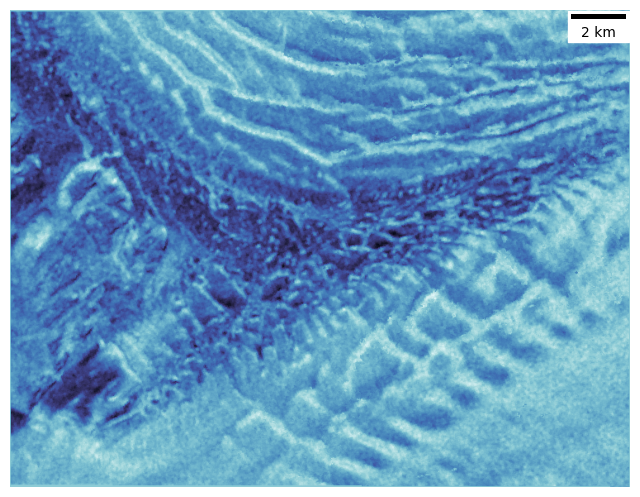

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


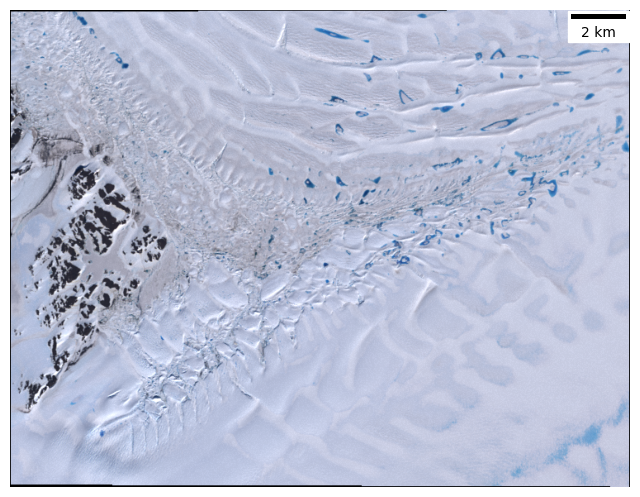

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


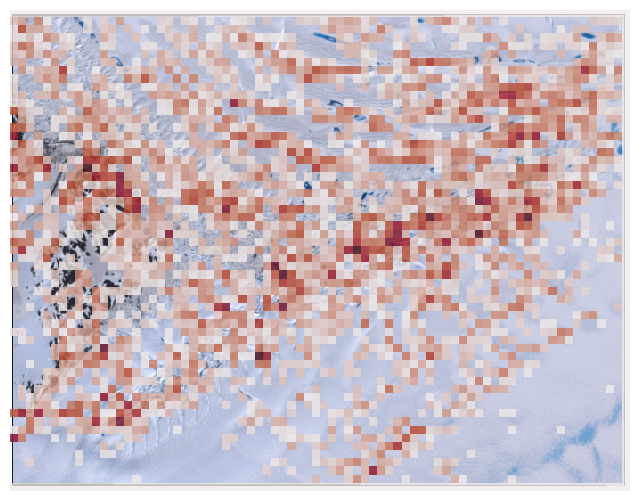

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


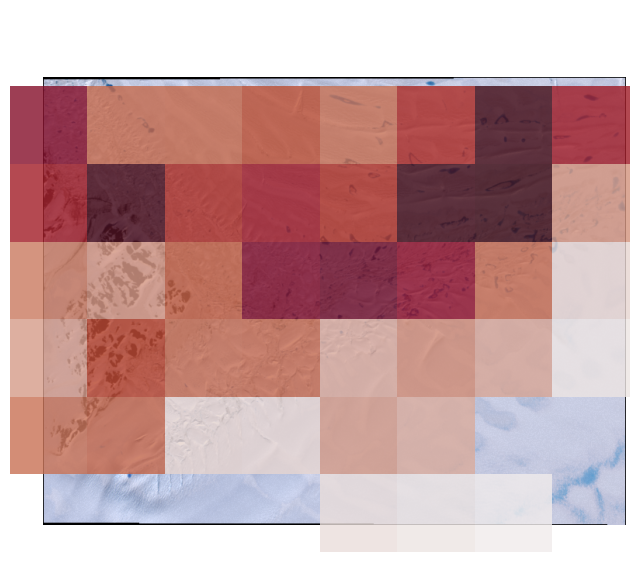

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


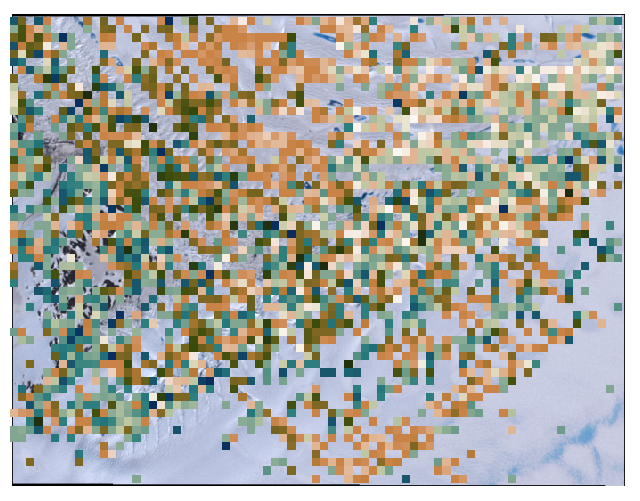

In [20]:
"""rgb"""
with rasterio.open(os.path.join(settings.season_folder, w0.file_rgb)) as src:
    meta = src.meta
    rgb_clipped, rgb_transform = mask(dataset=src, shapes=[geom for geom in roi.data.rotate(sgl_utils.get_angle(roi.data))], crop=True)

"""S1"""
filename = "_".join([name, "S1_20191101", "20191110", "30m.tif"])
print(filename)
with rasterio.open(os.path.join(settings.dmg_folder, filename)) as src:
    meta = src.meta
    S1_clipped, S1_transform = mask(dataset=src, shapes=[geom for geom in roi.data.rotate(sgl_utils.get_angle(roi.data))], crop=True)

"""dmg"""
with rasterio.open(os.path.join(settings.dmg_folder, w0.file_dmg)) as src:
    meta = src.meta
    dmg_clipped, dmg_transform = mask(dataset=src, shapes=[geom for geom in roi.data.rotate(sgl_utils.get_angle(roi.data))], crop=True)

filename = "_".join([settings.region.lower(), coll.rangestart, coll.rangeend, str(int(target_res)) + "m", "dmg.tif"])
with rasterio.open(os.path.join(settings.dmg_folder, filename)) as src:
    meta = src.meta
    median = np.nanmedian(src.read())
    dmg_resampled, dmg_resampled_transform = mask(dataset=src, shapes=[geom for geom in roi.data.rotate(sgl_utils.get_angle(roi.data))], crop=True)


"""crev angle"""
with rasterio.open(os.path.join(r"D:\[NOT SYNC]\ASRP_Data\shackleton_S1_30m\tile-182_S1_20191101_20191110_30m_output_10px_alphaC.tif")) as src:
    meta = src.meta
    alpha_c_clipped, alpha_c_transform = mask(dataset=src, shapes=[geom for geom in roi.data.rotate(sgl_utils.get_angle(roi.data))], crop=True)


dx = rgb_clipped.shape[1]
dy = rgb_clipped.shape[2]
size = 8
fig, ax = plt.subplots(figsize = (size, size * dy / dx))
rplt.show(S1_clipped, transform = S1_transform, ax = ax, cmap = cmo.ice)
ax.add_artist(ScaleBar(1))
ax.set_yticks([])
ax.set_xticks([])
ax.axis('off')
plt.show()

dx = rgb_clipped.shape[1]
dy = rgb_clipped.shape[2]
size = 8
fig, ax = plt.subplots(figsize = (size, size * dy / dx))
rplt.show(rgb_clipped, transform = rgb_transform, ax = ax, cmap = cmo.ice)
ax.add_artist(ScaleBar(1))
ax.set_yticks([])
ax.set_xticks([])
ax.axis('off')
plt.show()


fig, ax = plt.subplots(figsize = (size, size * dy / dx))
rplt.show(rgb_clipped, transform = rgb_transform, ax = ax)

rplt.show(dmg_clipped, transform = dmg_transform, ax = ax,  cmap = cmo.amp, alpha = 0.8)

ax.set_yticks([])
ax.set_xticks([])
ax.axis('off')
plt.show()

fig, ax = plt.subplots(figsize = (size, size * dy / dx))
rplt.show(rgb_clipped, transform = rgb_transform, ax = ax)
dmg_resampled[dmg_resampled <= median] = np.nan
rplt.show(dmg_resampled, transform = dmg_resampled_transform, ax = ax,  cmap = cmo.amp, alpha = 0.8)
ax.set_yticks([])
ax.set_xticks([])
ax.axis('off')
plt.show()

fig, ax = plt.subplots(figsize = (size, size * dy / dx))
rplt.show(rgb_clipped, transform = rgb_transform, ax = ax)
dmg_mask = np.zeros(dmg_clipped.shape)
dmg_mask = dmg_mask * np.nan
dmg_mask[dmg_clipped > 0] = 1
rplt.show(alpha_c_clipped*dmg_mask, transform = alpha_c_transform, ax = ax,  cmap = cmo.tarn, alpha = 1, vmin = -90, vmax = 90)
ax.set_yticks([])
ax.set_xticks([])
ax.axis('off')
plt.show()

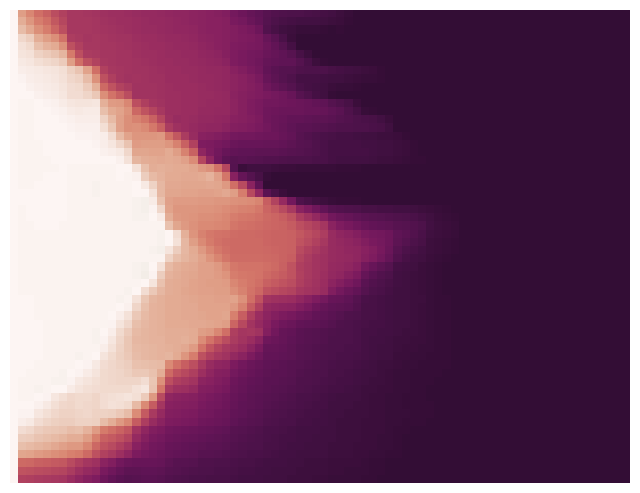

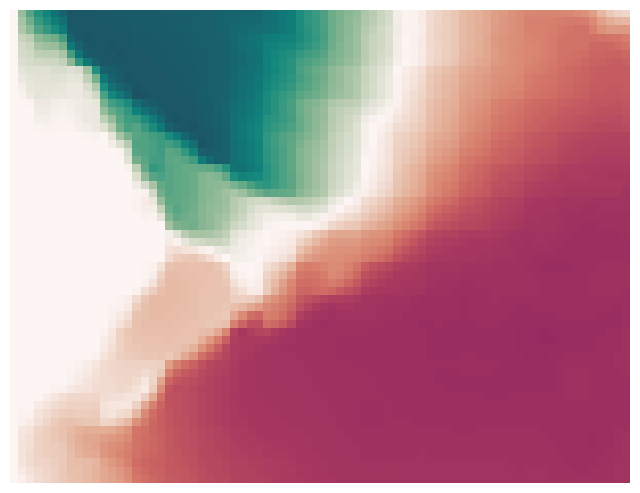

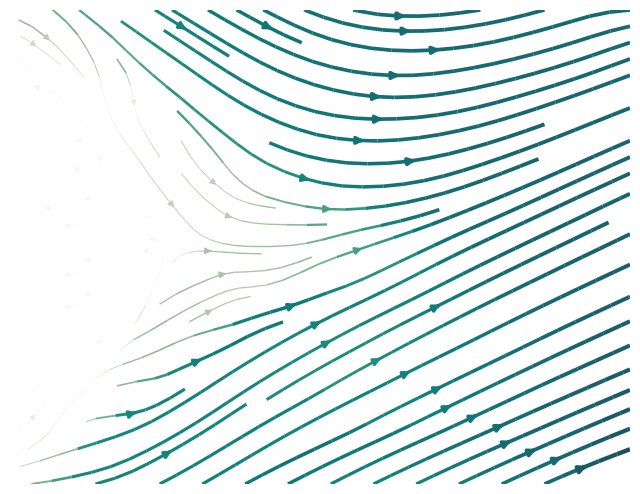

C:\Users\js-ms\AppData\Local\Temp\ipykernel_20664\4246372619.py:46: RuntimeWarning: invalid value encountered in true_divide
  angle = np.arctan(vy_clipped/vx_clipped)/(2*np.pi) * 360


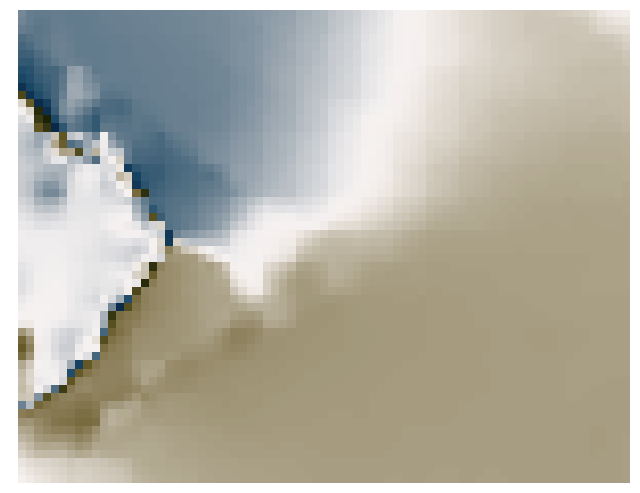

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


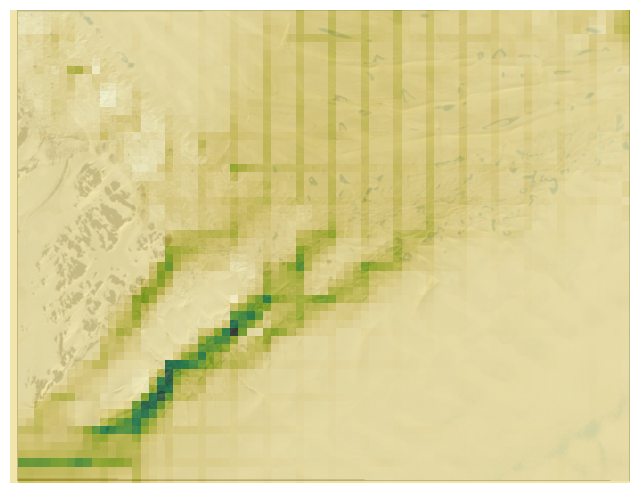

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


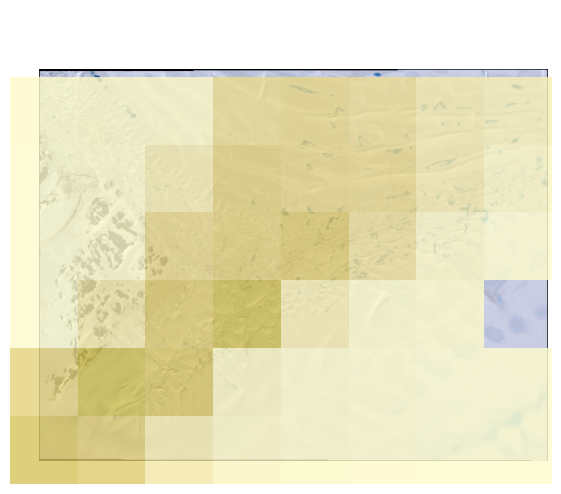

In [21]:
size = 8
"""rgb"""
with rasterio.open(os.path.join(settings.season_folder, w0.file_rgb)) as src:
    meta = src.meta
    rgb_clipped, rgb_transform = mask(dataset=src, shapes=[geom for geom in roi.data.rotate(sgl_utils.get_angle(roi.data))], crop=True)

"""velocity"""
with rasterio.open(os.path.join(settings.region_folder, w0.file_vx)) as src:
    meta = src.meta
    vx_clipped, vx_transform = mask(dataset=src, shapes=[geom for geom in roi.data.rotate(sgl_utils.get_angle(roi.data))], crop=True)
with rasterio.open(os.path.join(settings.region_folder, w0.file_vy)) as src:
    meta = src.meta
    vy_clipped, vy_transform = mask(dataset=src, shapes=[geom for geom in roi.data.rotate(sgl_utils.get_angle(roi.data))], crop=True)
dx = rgb_clipped.shape[1]
dy = rgb_clipped.shape[2]
fig, ax = plt.subplots(figsize = (size, size * dy / dx))
rplt.show(vx_clipped, transform =  vx_transform, ax = ax,  cmap = cmo.curl, vmin = -400, vmax = 400)
ax.set_yticks([])
ax.set_xticks([])
ax.axis('off')
plt.show()

fig, ax = plt.subplots(figsize = (size, size * dy / dx))
rplt.show(vy_clipped, transform =  vy_transform, ax = ax,  cmap = cmo.curl, vmin = -400, vmax = 400)
ax.set_yticks([])
ax.set_xticks([])
ax.axis('off')
plt.show()


"""Flow field"""
xs = np.linspace(0, 1, vx_clipped.shape[-1])
ys = np.linspace(0, 1, vx_clipped.shape[-2])
X, Y = np.meshgrid(xs, ys)
speed = np.sqrt(vx_clipped**2 + vy_clipped**2)
lw = 4*speed[0] / speed.max()

fig, ax = plt.subplots(figsize = (size, size * dx / dy))
ax.streamplot(X, Y, vx_clipped[0], np.flipud(vy_clipped[0]), linewidth = lw, color = speed[0], cmap = cmo.tempo)
ax.set_yticks([])
ax.set_xticks([])
ax.axis('off')
plt.show()

"""Flow Angle"""
angle = np.arctan(vy_clipped/vx_clipped)/(2*np.pi) * 360

fig, ax = plt.subplots(figsize = (size, size * dx / dy))
rplt.show(angle, transform = vy_transform, ax = ax,  cmap = cmo.diff, vmin = -90, vmax = 90)
ax.set_yticks([])
ax.set_xticks([])
ax.axis('off')
plt.show()


"""Strain"""
with rasterio.open(os.path.join(settings.region_folder, w0.file_emax)) as src:
    meta = src.meta
    emax_clipped, emax_transform = mask(dataset=src, shapes=[geom for geom in roi.data.rotate(sgl_utils.get_angle(roi.data))], crop=True)
fig, ax = plt.subplots(figsize = (size, size * dx / dy))
rplt.show(rgb_clipped, transform = rgb_transform, ax = ax)
rplt.show(emax_clipped, transform = emax_transform, ax = ax,  cmap = cmo.speed, alpha = 0.8)
ax.set_yticks([])
ax.set_xticks([])
ax.axis('off')
plt.show()

with rasterio.open(r"D:\[NOT SYNC]\ASRP_Data\shackleton\shackleton_3000m_emax.tif") as src:
    meta = src.meta
    median = np.nanmedian(src.read())
    emax_resampled, emax_resampled_transform = mask(dataset=src, shapes=[geom for geom in roi.data.rotate(sgl_utils.get_angle(roi.data))], crop=True)
fig, ax = plt.subplots(figsize = (size, size * dx / dy))
rplt.show(rgb_clipped, transform = rgb_transform, ax = ax)
emax_resampled[emax_resampled <= median] = np.nan
rplt.show(emax_resampled, transform = emax_resampled_transform, ax = ax,  cmap = cmo.speed, alpha = 0.8, vmax = 0.42)
ax.set_yticks([])
ax.set_xticks([])
ax.axis('off')
plt.show()




Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


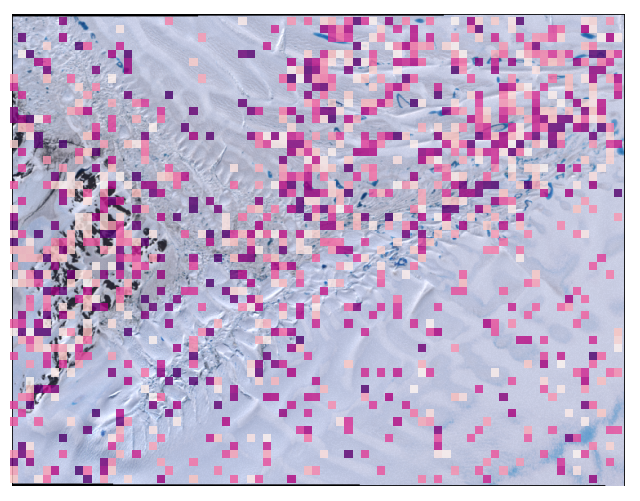

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


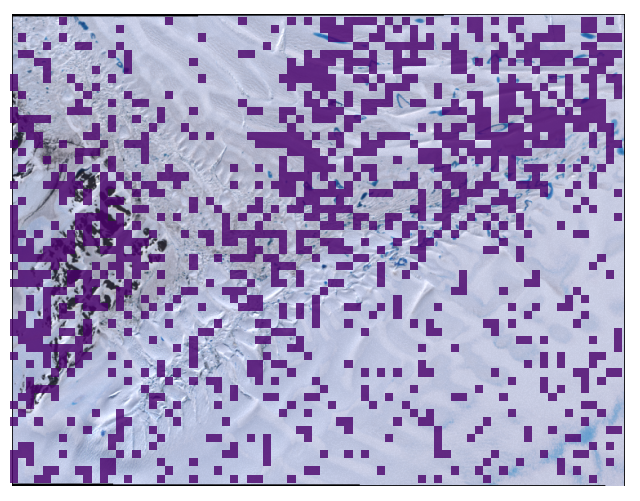

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


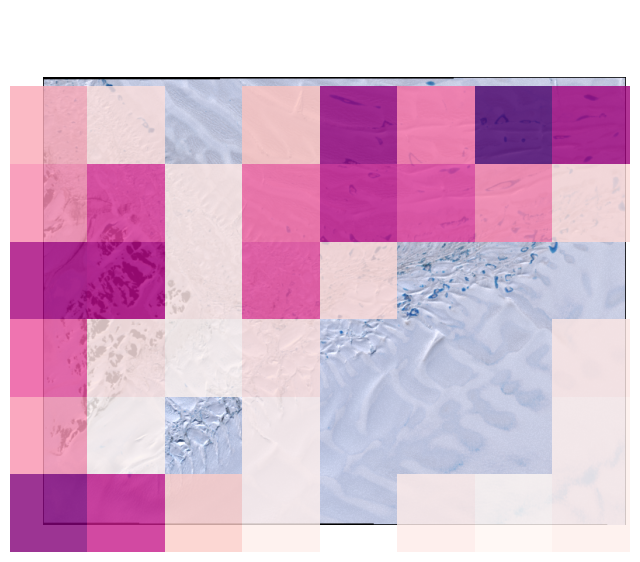

In [19]:
date = "2020-01-22"
w_shape = rcoll.get("E")
name = "tile-182"
target_res = 3000
w0 = [w for w in coll.windows if w.metadata["date"] == date and w.name == name][0]

"""rgb"""
with rasterio.open(os.path.join(settings.season_folder, w0.file_rgb)) as src:
    meta = src.meta
    rgb_clipped, rgb_transform = mask(dataset=src, shapes=[geom for geom in roi.data.rotate(sgl_utils.get_angle(roi.data))], crop=True)

"""activeness"""
with rasterio.open(os.path.join(settings.dmg_folder, w0.file_delta_alpha_c)) as src:
    meta = src.meta
    delta_clipped, delta_transform = mask(dataset=src, shapes=[geom for geom in roi.data.rotate(sgl_utils.get_angle(roi.data))], crop=True)

crev_active = sgl_utils.create_active_crevasses_mask(delta_clipped, 45, 15)
crev_mask = np.zeros(crev_active.shape)
crev_mask[np.nan_to_num(crev_active, nan = -1) >= 0] = 1

filename = "_".join([settings.region.lower(), coll.rangestart, coll.rangeend, str(int(target_res)) + "m", "crev.tif"])
with rasterio.open(os.path.join(settings.dmg_folder, filename)) as src:
    meta = src.meta
    median = np.nanmedian(src.read())
    crev_resampled, crev_resampled_transform = mask(dataset=src, shapes=[geom for geom in roi.data.rotate(sgl_utils.get_angle(roi.data))], crop=True)

fig, ax = plt.subplots(figsize = (size, size * dy / dx))
rplt.show(rgb_clipped, transform = rgb_transform, ax = ax)
crev_mask[crev_mask <= 0] = np.nan
rplt.show(crev_active, transform = delta_transform, ax = ax,  cmap = "RdPu", alpha = 0.8)
ax.set_yticks([])
ax.set_xticks([])
ax.axis('off')
plt.show()

fig, ax = plt.subplots(figsize = (size, size * dy / dx))
rplt.show(rgb_clipped, transform = rgb_transform, ax = ax)
rplt.show(crev_mask, transform = delta_transform, ax = ax,  cmap = "RdPu_r", alpha = 0.8)
ax.set_yticks([])
ax.set_xticks([])
ax.axis('off')
plt.show()

fig, ax = plt.subplots(figsize = (size, size * dy / dx))
rplt.show(rgb_clipped, transform = rgb_transform, ax = ax)
crev_resampled[crev_resampled <= median] = np.nan
rplt.show(crev_resampled, transform = crev_resampled_transform, ax = ax,  cmap = "RdPu", alpha = 0.8)
ax.set_yticks([])
ax.set_xticks([])
ax.axis('off')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


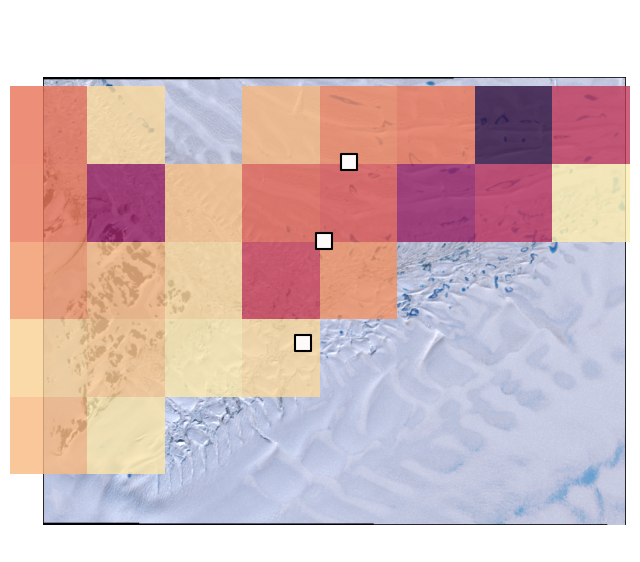

In [ ]:
"""rgb"""
with rasterio.open(os.path.join(settings.season_folder, w0.file_rgb)) as src:
    meta = src.meta
    rgb_clipped, rgb_transform = mask(dataset=src, shapes=[geom for geom in roi.data.rotate(sgl_utils.get_angle(roi.data))], crop=True)


"""Weakness"""
filename = "_".join([settings.region.lower(), coll.rangestart, coll.rangeend, str(int(target_res)) + "m", "weak.tif"])
with rasterio.open(os.path.join(settings.dmg_folder, filename)) as src:
    meta = src.meta
    median = np.nanmedian(src.read())
    weak_resampled, weak_resampled_transform = mask(dataset=src, shapes=[geom for geom in roi.data.rotate(sgl_utils.get_angle(roi.data))], crop=True)

fig, ax = plt.subplots(figsize = (size, size * dy / dx))
rplt.show(rgb_clipped, transform = rgb_transform, ax = ax)
"""true positive"""  
drains19[(drains19["criteria"].isin(positive_drains19)) & (drains19["window"] == 0)].centroid.plot(ax = ax, marker = "s", markersize = 140, linewidth = 1.5, facecolor="snow", edgecolor="black", zorder = 100, label = f"{coll19.rangestart[0:4]}/{coll19.rangeend[2:4]}")
drains18[(drains18["criteria"].isin(positive_drains18)) & (drains18["window"] == 0)].centroid.plot(ax = ax, marker = "*", markersize = 140, linewidth = 1.5, facecolor="snow", edgecolor="black", zorder = 102, label = f"{coll19.rangestart[0:4]}/{coll19.rangeend[2:4]}")
drains20[(drains20["criteria"].isin(positive_drains20)) & (drains20["window"] == 0)].centroid.plot(ax = ax, marker = "<", markersize = 140, linewidth = 1.5, facecolor="snow", edgecolor="black", zorder = 101, label = f"{coll19.rangestart[0:4]}/{coll19.rangeend[2:4]}")

weak_resampled[weak_resampled <= median] = np.nan
rplt.show(weak_resampled, transform = weak_resampled_transform, ax = ax,  cmap = cmo.matter, alpha = 0.8)
ax.set_yticks([])
ax.set_xticks([])
ax.axis('off')
plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


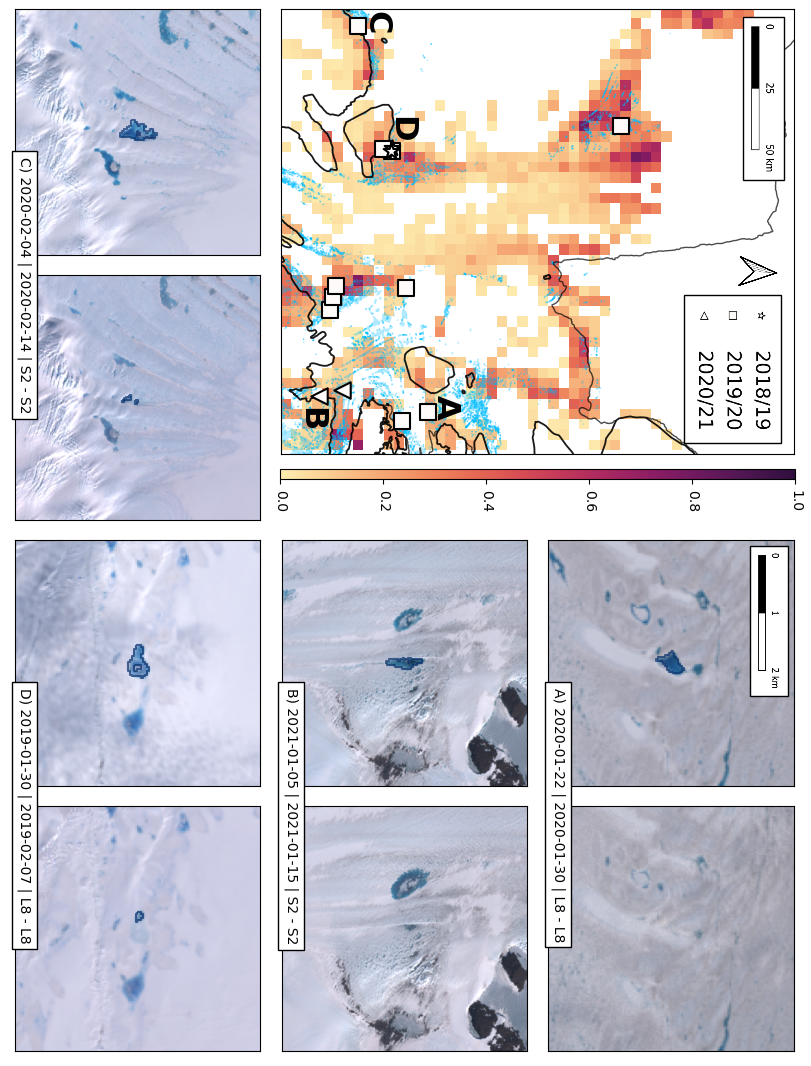

In [12]:
criteriaA = "tile-1812020-01-224472020-01-30L8L8drain"
collA = coll19
drainsA = drains19
settingsA= settings19
drainA = drains19[drains19["criteria"] == criteriaA].reset_index()
drainA0 = drainA[drainA["window"] == 0].dissolve()
#drainA1 = drainA[drainA["window"] == 1].dissolve()

criteriaB = "tile-1812021-01-051182021-01-15S2S2drain"
collB = coll20
drainsB = drains20
settingsB = settings20
drainB = drainsB[drainsB["criteria"] == criteriaB].reset_index()
drainB0 = drainB[drainB["window"] == 0].dissolve()
#drainB1 = drainB[drainB["window"] == 1].dissolve()

criteriaC = "tile-1822020-02-041942020-02-14S2S2shrink"
collC = coll19
drainsC = drains19
settingsC = settings19
drainC = drainsC[drainsC["criteria"] == criteriaC].reset_index()
drainC0 = drainC[drainC["window"] == 0].dissolve()
drainC1 = drainC[drainC["window"] == 1].dissolve()

criteriaD = "tile-1822019-01-303002019-02-07L8L8shrink"
collD = coll18
drainsD = drains18
settingsD = settings18
drainD = drainsD[drainsD["criteria"] == criteriaD].reset_index()
drainD0 = drainD[drainD["window"] == 0].dissolve()
drainD1 = drainD[drainD["window"] == 1].dissolve()

offset = 2e3

"""Big Window"""
legend = img.imread(r"D:\[NOT SYNC]\ASRP_Data\images\legend.png")
arrow = img.imread(r"D:\[NOT SYNC]\ASRP_Data\images\arrow.png")
scale2 = img.imread(r"D:\[NOT SYNC]\ASRP_Data\images\scale2.png")

legend_box = OffsetImage(legend, zoom = 0.30)
legend_abox = AnnotationBbox(legend_box, xy = (0.88, 0.19), xycoords = 'axes fraction')
arrow_box = OffsetImage(arrow, zoom = 0.14)
arrow_abox = AnnotationBbox(arrow_box, xy = (0.93, 0.41), xycoords = 'axes fraction', frameon = False)
scale2_box = OffsetImage(scale2, zoom = 0.30)
scale2_abox = AnnotationBbox(scale2_box, xy = (0.94, 0.80), xycoords = 'axes fraction')
dx = 150e3
dy = 130e3

left = 2540895.00
right = left + dx

bottom = -490e3
top = bottom + dy
polygon = Polygon([(left, bottom), (left, top), (right, top), (right, bottom), (left, bottom)])

filename = "_".join([settings.region.lower(), coll.rangestart, coll.rangeend, str(int(target_res)) + "m", "dmg.tif"])
with rasterio.open(r"D:\[NOT SYNC]\ASRP_Data\shackleton_S1_30m\shackleton_20191201_20200331_3000m_weak.tif") as src:
    weak = src.read(window = rw.from_bounds(left, bottom, right, top, src.transform))
    weak_transform = Affine(src.transform[0], 0, left,
                        0, src.transform[4], top)

shape = (4, 3)
fig, ax = plt.subplots(figsize = (8.2, 10.8))
ax0 = plt.subplot2grid(shape=shape, loc=(0, 1), colspan=2, rowspan=2)
weak_base = ax0.imshow(weak[0], cmap = cmo.matter, vmin = 0, vmax = 1)
plt.close()

fig = plt.figure(figsize = (8.2, 10.8))


ax0 = plt.subplot2grid(shape=shape, loc=(0, 1), colspan=2, rowspan=2)
axA0 = plt.subplot2grid(shape=shape, loc=(2, 2))
axA1 = plt.subplot2grid(shape=shape, loc=(3, 2))
axB0 = plt.subplot2grid(shape=shape, loc=(2, 1))
axB1 = plt.subplot2grid(shape=shape, loc=(3, 1))
axC0 = plt.subplot2grid(shape=shape, loc=(0, 0))
axC1 = plt.subplot2grid(shape=shape, loc=(1, 0))
axD0 = plt.subplot2grid(shape=shape, loc=(2, 0))
axD1 = plt.subplot2grid(shape=shape, loc=(3, 0))


set_share_axes(np.array([axA0, axA1]), sharex=True, sharey=True)
set_share_axes(np.array([axB0, axB1]), sharex=True, sharey=True)



ax = ax0
rplt.show(weak, transform = weak_transform, ax = ax, cmap = cmo.matter, vmin = 0, vmax = 1)
shelf_lines.cx[xmin_total:xmax_total, ymin_total:ymax_total].plot(ax = ax, facecolor="none", edgecolor='black', lw=1, alpha = 0.7)
grounding_lines.cx[xmin_total:xmax_total, ymin_total:ymax_total].plot(ax = ax, facecolor="none", edgecolor='black', lw=1.3, alpha = 0.9)
drains19[(drains19["criteria"].isin(positive_drains19)) & (drains19["window"] == 0)].centroid.plot(ax = ax, marker = "s", markersize = 140, linewidth = 1.5, facecolor="snow", edgecolor="black", zorder = 100, label = f"{coll19.rangestart[0:4]}/{coll19.rangeend[2:4]}")
drains18[(drains18["criteria"].isin(positive_drains18)) & (drains18["window"] == 0)].centroid.plot(ax = ax, marker = "*", markersize = 140, linewidth = 1.5, facecolor="snow", edgecolor="black", zorder = 102, label = f"{coll19.rangestart[0:4]}/{coll19.rangeend[2:4]}")
drains20[(drains20["criteria"].isin(positive_drains20)) & (drains20["window"] == 0)].centroid.plot(ax = ax, marker = "<", markersize = 140, linewidth = 1.5, facecolor="snow", edgecolor="black", zorder = 101, label = f"{coll19.rangestart[0:4]}/{coll19.rangeend[2:4]}")
lakeextent19.buffer(200).plot(ax = ax, markersize = 60, color = "deepskyblue", alpha = 0.3)
ax.text(x = drainA0.centroid.x + 0.7e3, y = drainA0.centroid.y + 0e3, s = "A", fontsize = 23, weight='bold', rotation = -90) #- 7e3- 8e3
ax.text(x = drainB0.centroid.x - 7e3, y = drainB0.centroid.y - 8e3, s = "B", fontsize = 23, weight='bold', rotation = -90)
ax.text(x = drainC0.centroid.x + 0.7e3, y = drainC0.centroid.y + 0e3 , s = "C", fontsize = 23, weight='bold', rotation = -90)
ax.text(x = drainD0.centroid.x - 2e3, y = drainD0.centroid.y + 4e3, s = "D", fontsize = 23, weight='bold', rotation = -90)
ax.set_xlim(left, right)
ax.set_ylim(bottom, top)
ax.set_yticks([])
ax.set_xticks([])

cbar = fig.colorbar(weak_base, ax=ax, orientation = "horizontal", shrink = 1, location = "bottom", pad = 0.03, fraction = 0.1, aspect = 50)#, pad = 0.5)
cbar.ax.tick_params(rotation=-90, labelsize=10)
ax.add_artist(legend_abox)
ax.add_artist(arrow_abox)
ax.add_artist(scale2_abox)


"""Lake A"""
wA0 = [w for w in collA.windows if w.name == drainA0["name"].iloc[0] and w.metadata["date"] == drainA0["date-0"].iloc[0]][0]
wA1 = [w for w in collA.windows if w.name == drainA0["name"].iloc[0] and w.metadata["date"] == drainA0["date-1"].iloc[0]][0]
minx = min(drainA0.centroid.x) - offset
miny = min(drainA0.centroid.y) - offset
maxx = max(drainA0.centroid.x) + offset
maxy = max(drainA0.centroid.y) + offset
dx = maxx - minx
dy = maxy - miny

with rasterio.open(os.path.join(settingsA.season_folder, wA0.file_rgb)) as src:
    rgb0 = src.read(window = rw.from_bounds(minx, miny, maxx, maxy, src.transform))
    rgb0_transform = Affine(src.transform[0], 0, minx,
                        0, src.transform[4], maxy)
with rasterio.open(os.path.join(settingsA.season_folder, wA1.file_rgb)) as src:
    rgb1 = src.read(window = rw.from_bounds(minx, miny, maxx, maxy, src.transform))
    rgb1_transform = Affine(src.transform[0], 0, minx,
                        0, src.transform[4], maxy)
ax = axA0
rplt.show(rgb0, transform = rgb0_transform, ax = ax)
drainA0.boundary.plot(ax = ax, cmap = "Blues_r", alpha = 0.7)
fig.text(.01, .40, "A) " + drainA0["date-0"].iloc[0] + " | " + drainA0["date-1"].iloc[0] + " | " + drainA0["sat-0"].iloc[0] + " - " + drainA0["sat-1"].iloc[0], ha='left', va='top', transform=ax.transAxes, bbox=dict(facecolor="white"), rotation = -90)
ax.set_yticks([])
ax.set_xticks([])
scale3 = img.imread(r"D:\[NOT SYNC]\ASRP_Data\images\scale3.png")
scale3_box = OffsetImage(scale3, zoom = 0.28)
scale3_abox = AnnotationBbox(scale3_box, xy = (0.90, 0.67), xycoords = 'axes fraction')
ax.add_artist(scale3_abox)

ax = axA1
rplt.show(rgb1, transform = rgb1_transform, ax = ax)
#drainA1.boundary.plot(ax = ax, cmap = "Blues_r", alpha = 0.7)
ax.set_yticks([])
ax.set_xticks([])
#ax.add_artist(ScaleBar(1))



"""Lake B"""
wB0 = [w for w in collB.windows if w.name == drainB0["name"].iloc[0] and w.metadata["date"] == drainB0["date-0"].iloc[0]][0]
wB1 = [w for w in collB.windows if w.name == drainB0["name"].iloc[0] and w.metadata["date"] == drainB0["date-1"].iloc[0]][0]
minx = min(drainB0.centroid.x) - offset
miny = min(drainB0.centroid.y) - offset
maxx = max(drainB0.centroid.x) + offset
maxy = max(drainB0.centroid.y) + offset
dx = maxx - minx
dy = maxy - miny

with rasterio.open(os.path.join(settingsB.season_folder, wB0.file_rgb)) as src:
    rgb0 = src.read(window = rw.from_bounds(minx, miny, maxx, maxy, src.transform))
    rgb0_transform = Affine(src.transform[0], 0, minx,
                        0, src.transform[4], maxy)
with rasterio.open(os.path.join(settingsB.season_folder, wB1.file_rgb)) as src:
    rgb1 = src.read(window = rw.from_bounds(minx, miny, maxx, maxy, src.transform))
    rgb1_transform = Affine(src.transform[0], 0, minx,
                        0, src.transform[4], maxy)

ax = axB0
rplt.show(rgb0, transform = rgb0_transform, ax = ax)
drainB0.boundary.plot(ax = ax, cmap = "Blues_r", alpha = 0.7)
fig.text(.01, .40, "B) " + drainB0["date-0"].iloc[0] + " | " + drainB0["date-1"].iloc[0] + " | " + drainB0["sat-0"].iloc[0] + " - " + drainB0["sat-1"].iloc[0], ha='left', va='top', transform=ax.transAxes, bbox=dict(facecolor="white"), rotation = -90)
ax.set_yticks([])
ax.set_xticks([])
ax = axB1
rplt.show(rgb1, transform = rgb1_transform, ax = ax)
#drainB1.boundary.plot(ax = ax, cmap = "Blues_r", alpha = 0.7)
ax.set_yticks([])
ax.set_xticks([])

"""Lake C"""
wC0 = [w for w in collC.windows if w.name == drainC0["name"].iloc[0] and w.metadata["date"] == drainC0["date-0"].iloc[0]][0]
wC1 = [w for w in collC.windows if w.name == drainC0["name"].iloc[0] and w.metadata["date"] == drainC0["date-1"].iloc[0]][0]
minx = min(drainC0.centroid.x) - offset
miny = min(drainC0.centroid.y) - offset
maxx = max(drainC0.centroid.x) + offset
maxy = max(drainC0.centroid.y) + offset
dx = maxx - minx
dy = maxy - miny

with rasterio.open(os.path.join(settingsC.season_folder, wC0.file_rgb)) as src:
    rgb0 = src.read(window = rw.from_bounds(minx, miny, maxx, maxy, src.transform))
    rgb0_transform = Affine(src.transform[0], 0, minx,
                        0, src.transform[4], maxy)
with rasterio.open(os.path.join(settingsC.season_folder, wC1.file_rgb)) as src:
    rgb1 = src.read(window = rw.from_bounds(minx, miny, maxx, maxy, src.transform))
    rgb1_transform = Affine(src.transform[0], 0, minx,
                        0, src.transform[4], maxy)

ax = axC0
rplt.show(rgb0, transform = rgb0_transform, ax = ax)
drainC0.boundary.plot(ax = ax, cmap = "Blues_r", alpha = 0.7)
fig.text(.01, .40, "C) " + drainC0["date-0"].iloc[0] + " | " + drainC0["date-1"].iloc[0] + " | " + drainC0["sat-0"].iloc[0] + " - " + drainC0["sat-1"].iloc[0], ha='left', va='top', transform=ax.transAxes, bbox=dict(facecolor="white"), rotation = -90)
ax.set_yticks([])
ax.set_xticks([])
ax = axC1
rplt.show(rgb1, transform = rgb1_transform, ax = ax)
drainC1.boundary.plot(ax = ax, cmap = "Blues_r", alpha = 0.7)
ax.set_yticks([])
ax.set_xticks([])

"""Lake D"""
wD0 = [w for w in collD.windows if w.name == drainD0["name"].iloc[0] and w.metadata["date"] == drainD0["date-0"].iloc[0]][0]
wD1 = [w for w in collD.windows if w.name == drainD0["name"].iloc[0] and w.metadata["date"] == drainD0["date-1"].iloc[0]][0]
minx = min(drainD0.centroid.x) - offset
miny = min(drainD0.centroid.y) - offset
maxx = max(drainD0.centroid.x) + offset
maxy = max(drainD0.centroid.y) + offset
dx = maxx - minx
dy = maxy - miny

with rasterio.open(os.path.join(settingsD.season_folder, wD0.file_rgb)) as src:
    rgb0 = src.read(window = rw.from_bounds(minx, miny, maxx, maxy, src.transform))
    rgb0_transform = Affine(src.transform[0], 0, minx,
                        0, src.transform[4], maxy)
with rasterio.open(os.path.join(settingsD.season_folder, wD1.file_rgb)) as src:
    rgb1 = src.read(window = rw.from_bounds(minx, miny, maxx, maxy, src.transform))
    rgb1_transform = Affine(src.transform[0], 0, minx,
                        0, src.transform[4], maxy)

ax = axD0
rplt.show(rgb0, transform = rgb0_transform, ax = ax)
drainD0.boundary.plot(ax = ax, cmap = "Blues_r", alpha = 0.7)
fig.text(.01, .40, "D) " + drainD0["date-0"].iloc[0] + " | " + drainD0["date-1"].iloc[0] + " | " + drainD0["sat-0"].iloc[0] + " - " + drainD0["sat-1"].iloc[0], ha='left', va='top', transform=ax.transAxes, bbox=dict(facecolor="white"), rotation = -90)  
ax.set_yticks([])
ax.set_xticks([])
ax = axD1
rplt.show(rgb1, transform = rgb1_transform, ax = ax)
drainD1.boundary.plot(ax = ax, cmap = "Blues_r", alpha = 0.7)
ax.set_yticks([])
ax.set_xticks([])

plt.tight_layout()
plt.show()


In [41]:
gpd.GeoDataFrame({"name" : ["A", "B"], "geometry" : [polygon, roi.data.rotate(sgl_utils.get_angle(roi.data))[0]]}).to_file(os.path.join(settings.region_folder, "interesting_roi.shp"))

d:\Programme\Anaconda\lib\site-packages\geopandas\io\file.py:299: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
